Sample 1: [9.206 5.806 9.795 7.452], 0.014636
Sample 2: [9.123 5.265 8.88  5.74 ], 0.011781
Sample 3: [0.661 2.222 3.34  7.025], 2.3e-05
Sample 4: [2.022 2.641 2.202 2.139], 3.2e-05
Sample 5: [0.501 2.135 3.23  1.475], 8.6e-05
Sample 6: [0.363 1.749 2.184 1.032], 1.7e-05
Sample 7: [5.306 5.682 0.108 5.365], 0.001569
Sample 8: [0.608 8.135 1.662 2.234], 0.004223
Sample 9: [5.049 3.675 4.728 4.297], 0.000879
Sample 10: [7.569 8.265 5.136 5.122], 0.006847
Sample 11: [0.16  6.248 5.637 4.814], 0.001882
Sample 12: [3.649 6.6   2.837 8.771], 0.001704
{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=1) + Matern(length_scale=1, nu=1.5) * DotProduct(sigma_0=1)}
-1.1916759573008516e-06
-0.007413322805776849
{'alpha': 1e-09, 'kernel__k1__sigma_0': 10, 'kernel__k2__k1__length_scale': 0.1, 'kernel__k2__k2__sigma_0': 10000}
-7.399265034298152e-07
-0.0007581675406148667
Concentration (ppm)        | Conductivity (S/m)
10.0, 10.0, 10.0, 2.677    | 0.027250
10.0, 0.0, 10.0, 1.555     | 0.020354
10.0, 10.0,

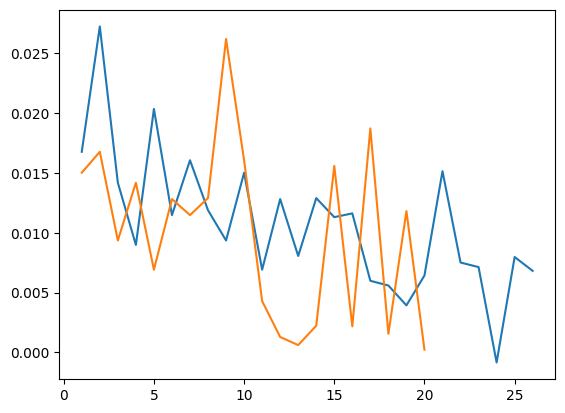

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X):
    return (rosen(X) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)   #Initializes the initial set of concentrations
y = conductivity_func(X.T).round(6)                               #Initializes the initial set of conductivities

for i in range(len(y)):                                         #Prints all values
    print(f'Sample {i+1}: {X[i]}, {y[i]}')

#===========================================================================================================#
#Declaring Machine Learning Model Used

#kernel = Matern(length_scale=1e+04, nu=1.5, length_scale_bounds=(100.0, 10000.0)) * DP(sigma_0=1e+04, sigma_0_bounds=(1.0, 100000.0))
#GPR = GaussianProcessRegressor(kernel = kernel, alpha=1e-3, normalize_y=True)
#kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))   #Best parameters from initial testing
kernel = 1e+05 * RBF(length_scale=1, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+05, sigma_0_bounds=(0.001, 10000.0))
GPR = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-10)                                                       #Forms ML model from said parameters


#===========================================================================================================#
#Bayesian Optimization

def guess_in_bounds(bounds):                                                #This function produces guess values within a specfied bound
    return [(b[1] - b[0]) * np.random.random() + b[0] for b in bounds]

#The following functions are different acquisition functions to be used for Bayesian Optimization

def upper_conf_bound(x, model, explore_weight):          #Upper Confidence Bound Acquisition Function
    pred, std = model.predict([x], return_std=True)
    return -(pred+std*explore_weight)

def probability_improve(x, model, best_y):             #Probability of Improvement
    pred, std = model.predict([x], return_std=True)
    return -(norm.cdf((pred-best_y)/std))

def expected_improvement(x, model, best_y, xi):           #Expected Improvement Acquisition Function
    pred, std = model.predict([x], return_std=True)
    return -(pred-best_y-xi)*(norm.cdf((pred-best_y-xi)/std)+norm.pdf((pred-best_y-xi)/std))

bounds = [(0., 10.)] * concentrations

#===========================================================================================================#
#Global Minimum

samples_per_method = 6
ucb_exploration_weight = 5
xi = 0.5

def in_list(arr, lst): #This function compares an array with a list of arrays to see if the array is already present
    if lst == []:
        return False
    for item in lst:
        if np.allclose(arr, item, atol=1e-3):
            return True
    return False

def ML_func(guess, model):
    return -model.predict(guess.reshape(1, -1))

def save_points(old_mins, new_mins):
    old_x = [mins[0] for mins in old_mins]
    new_x = [mins[0] for mins in new_mins]
    points_added = 0
    index = 0
    while points_added < samples_per_method:
        if in_list(new_x[index], old_x) == False:
            old_mins.append((new_mins[index][0].tolist(), new_mins[index][1]))
            points_added += 1
        index += 1
    return old_mins

def new_experiments1(concentrations, conductivities, graph = False):
    bayes_model = clone(GPR).fit(concentrations, conductivities)
    model = clone(GPR).fit(concentrations, conductivities)
    func_mins = []
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    iterations = 20
    
    #==========================================================================================#
    #Non-Bayesian Optimization
    current_iteration = 0
    while (current_iteration<iterations):
        np.random.seed(current_iteration)
        guess = guess_in_bounds(bounds)
        func_min = minimize(ML_func, guess, bounds=bounds, method='Nelder-Mead', args=(model))
        x_guess = func_min.x.round(3)
        y_guess = func_min.fun.round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(y_guess)
            func_mins.append((x_guess, -y_guess))
        current_iteration += 1
    
    #==========================================================================================#
    #Bayesian Optimization with Upper Bound Confidence
    current_iteration = 0
    while (current_iteration<iterations) or (len(func_mins)<samples_per_method):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(upper_conf_bound, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, ucb_exploration_weight))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    if graph == True:
        x_axis = np.arange(1, len(func_mins)+1)
        y_axis = [x[1] for x in func_mins]
        plt.plot(x_axis, y_axis)
    return sorted(func_mins, key=lambda x: x[1], reverse=True)

def new_experiments2(concentrations, conductivities, graph = False):
    bayes_model = clone(GPR).fit(concentrations, conductivities)
    model = clone(GPR).fit(concentrations, conductivities)
    func_mins = []
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    iterations = 10
    
    #==========================================================================================#
    #Bayesian Optimization with Probability of Improvement
    current_iteration = 0
    while (current_iteration<iterations):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(probability_improve, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, max(y_copy)))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    #==========================================================================================#
    #Bayesian Optimization with Expected Improvement
    current_iteration = 0
    while (current_iteration<iterations) or (len(func_mins)<samples_per_method):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(expected_improvement, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, max(y_copy), xi))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    if graph == True:
        x_axis = np.arange(1, len(func_mins)+1)
        y_axis = [x[1] for x in func_mins]
        plt.plot(x_axis, y_axis)
    return sorted(func_mins, key=lambda x: x[1], reverse=True)
    
new_points_1 = new_experiments1(X, y)
new_points_2 = new_experiments2(X, y)

new_points = []
save_points(new_points, new_points_1) 
save_points(new_points, new_points_2) 

new_points = sorted(new_points, key=lambda x: x[1], reverse=True)

#print(f"{'Concentration (ppm)':<26} | {'Conductivity (S/m)'}")
for point in new_points:
    X=np.vstack((X, point[0]))
    y=np.hstack((y, conductivity_func(point[0]).round(6)))
    #formatted_list = ', '.join(map(str, point[0]))
    #print(f"{formatted_list:<26} | {point[1]:.6f}")

#===========================================================================================================#


kernel = DP(sigma_0=10) + Matern(length_scale=0.1, nu=1.5) * DP(sigma_0=10000)
GPR = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-10)          

#===========================================================================================================#
'''for i in range(len(y)):                                         #Prints all values
    print(f'Sample {i+1}: {X[i]}, {y[i]}')'''

new_points_3 = new_experiments1(X, y, graph=True)
new_points_4 = new_experiments2(X, y, graph=True)

new_points = []
save_points(new_points, new_points_3) 
save_points(new_points, new_points_4) 

print(f"{'Concentration (ppm)':<26} | {'Conductivity (S/m)'}")
for point in new_points:
    X=np.vstack((X, point[0]))
    y=np.hstack((y, conductivity_func(point[0]).round(6)))
    formatted_list = ', '.join(map(str, point[0]))
    print(f"{formatted_list:<26} | {point[1]:.6f}")
    
for i in range(len(y)):                                         #Prints all values
    print(f'Sample {i+1}: {X[i]}, {y[i]}')



1. Finish function to save all x's and y's to single variable
2. Implement system so minimums not repeated?
3. Clean up variable names

In [18]:
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)
y = conductivity_func(X).round(6)

'''for i in range(len(y)):
    print(f'Sample {i+1}: {X[i]}, {y[i]}')'''

#===========================================================================================================#
#Declaring Machine Learning Model Used

model = GaussianProcessRegressor(normalize_y=True)

def range_append(lower, upper):
    lst = []
    for exp in range(lower, upper):
        lst.append(10**exp)
    return lst

alpha = range_append(-10, -6)

kernel = [C(), W(), RBF(), Matern(), RQ(), ESS(), DP()]
operation = [Sum, Product]

operation_list = []
for op1 in operation:
    for op2 in operation:
        for kern1 in kernel:
            for kern2 in kernel:
                for kern3 in kernel:
                    operation_list.append(op1(kern1, op2(kern2, kern3)))
                    
#===========================================================================================================#

param_grid = [
    {'kernel': operation_list,
     'alpha': alpha}
]

param_search1 = GridSearchCV(model, param_grid, n_jobs=-1, cv=11, scoring='neg_mean_squared_error',)
param_search1.fit(X, y)

best_param1 = param_search1.best_params_
best_score1 = param_search1.best_score_

#model = GaussianProcessRegressor(alpha=0, normalize_y=True)
print(best_param1)
print(best_score1)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())

#===========================================================================================================#

sigma_0 = range_append(-6, 6)
constant_value = range_append(-6, 6)
length_scale = range_append(-6, 6)

param_dist = {'kernel__k1__sigma_0': sigma_0,
              'kernel__k2__k1__constant_value': constant_value,
              'kernel__k2__k2__length_scale': length_scale,
              'alpha': alpha}

model = GaussianProcessRegressor(normalize_y=True, **best_param1)

param_search2 = GridSearchCV(model, param_dist, n_jobs=-1, cv=11, scoring='neg_mean_squared_error')
param_search2.fit(X, y)

best_param2 = param_search2.best_params_
best_score2 = param_search2.best_score_

print(best_param2)
print(best_score2)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())


{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=1) + 1**2 * RBF(length_scale=1)}
-5.535074378550914e-06
-0.003259498412910748
[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
{'alpha': 1e-10, 'kernel__k1__sigma_0': 100000, 'kernel__k2__k1__constant_value': 100000, 'kernel__k2__k2__length_scale': 1}
-5.2763984956988345e-06
-0.0012360976115956808


In [66]:
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)
y = conductivity_func(X).round(6)

'''for i in range(len(y)):
    print(f'Sample {i+1}: {X[i]}, {y[i]}')'''

#===========================================================================================================#
#Declaring Machine Learning Model Used

model = GaussianProcessRegressor(normalize_y=True)

def range_append(lower, upper):
    lst = []
    for exp in range(lower, upper):
        lst.append(10**exp)
    return lst

def kernel_finder(model, X, y):
    alpha = range_append(-10, -6)

    kernel = [C(), W(), RBF(), Matern(), RQ(), ESS(), DP()]
    operation = [Sum, Product]

    operation_list = []
    for op1 in operation:
        for op2 in operation:
            for kern1 in kernel:
                for kern2 in kernel:
                    for kern3 in kernel:
                        operation_list.append(op1(kern1, op2(kern2, kern3)))
                        
    #===========================================================================================================#

    param_grid = [
        {'kernel': operation_list,
        'alpha': alpha}
    ]

    param_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=11, scoring='neg_mean_squared_error',)
    param_search.fit(X, y)

    best_param = param_search.best_params_
    best_score = param_search.best_score_
    #model = GaussianProcessRegressor(alpha=0, normalize_y=True)
    print(best_param)
    print(best_score)
    print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())
    return best_param

def kernel_optim(model, X, y):
    sigma_0 = range_append(-5, 6)
    constant_value = range_append(-5, 6)
    length_scale = range_append(-5, 6)
    alpha = range_append(-10, -6)

    #print(sigma_0)

    param_dist = {'kernel__k1__constant_value': constant_value,
                'kernel__k2__k1__length_scale': sigma_0,
                'kernel__k2__k2__length_scale': length_scale,
                'alpha': alpha}

    model = GaussianProcessRegressor(normalize_y=True, **best_param)

    param_search = RandomizedSearchCV(model, param_dist, n_jobs=-1, cv=11, scoring='neg_mean_squared_error')
    param_search.fit(X, y)

    best_param = param_search.best_params_
    best_score = param_search.best_score_
    
    print(best_param)
    print(best_score)
    print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())
    return 

kernel_finder(X, y)

{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=1) + 1**2 * RBF(length_scale=1)}
-5.535074378550914e-06
-0.003259498412910748
{'alpha': 1e-10, 'kernel': DotProduct(sigma_0=1) + 1**2 * RBF(length_scale=1)}


In [27]:
import numpy as np
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X, finding_min=False):
    if finding_min==False:
        return (rosen(X.T) * 1e-8).round(6)
    elif finding_min==True:
        return -(rosen(X.T) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)
y = conductivity_func(X).round(6)

'''for i in range(len(y)):
    print(f'Sample {i+1}: {X[i]}, {y[i]}')'''

#===========================================================================================================#
#Declaring Machine Learning Model Used

model = GaussianProcessRegressor(normalize_y=True)

def range_append(lower, upper):
    lst = []
    for exp in range(lower, upper):
        lst.append(10**exp)
    return lst

alpha = range_append(-10, -6)

kernel = [C(), W(), RBF(), Matern(), RQ(), ESS(), DP()]
operation = [Sum, Product]

operation_list = []
for op1 in operation:
    for op2 in operation:
        for kern1 in kernel:
            for kern2 in kernel:
                for kern3 in kernel:
                    operation_list.append(op1(kern1, op2(kern2, kern3)))
                    
#===========================================================================================================#

param_grid = [
    {'kernel': operation_list,
     'alpha': alpha}
]

param_search1 = RandomizedSearchCV(model, param_grid, n_jobs=-1, cv=11, scoring='neg_mean_squared_error',)
param_search1.fit(X, y)

best_param1 = param_search1.best_params_
best_score1 = param_search1.best_score_

#model = GaussianProcessRegressor(alpha=0, normalize_y=True)
print(best_param1)
print(best_score1)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())

#===========================================================================================================#

sigma_0 = range_append(-5, 6)
constant_value = range_append(-5, 6)
length_scale = range_append(-5, 6)

#print(sigma_0)

param_dist = {'kernel__k1__constant_value': constant_value,
              'kernel__k2__k1__length_scale': sigma_0,
              'kernel__k2__k2__length_scale': length_scale,
              'alpha': alpha}

model = GaussianProcessRegressor(normalize_y=True, **best_param1)

param_search2 = RandomizedSearchCV(model, param_dist, n_jobs=-1, cv=11, scoring='neg_mean_squared_error')
param_search2.fit(X, y)

best_param2 = param_search2.best_params_
best_score2 = param_search2.best_score_

print(best_param2)
print(best_score2)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())


{'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + RBF(length_scale=1), 'alpha': 1e-07}
-7.1520469908419184e-06
-0.003259498412910748
{'kernel__k2__k2__length_scale': 100, 'kernel__k2__k1__length_scale': 1e-05, 'kernel__k1__constant_value': 100, 'alpha': 1e-10}
-1.2732900242723579e-05
-0.001503022509695826


kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))

model = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-8)

score = -5.251450383038068e-06

error: -0.0012242895406499746


{'kernel': Matern(length_scale=1e+04, nu=1.5) * DotProduct(sigma_0=1e+04), 'kernel__k1__length_scale_bounds': (100.0, 10000.0), 'kernel__k2__sigma_0_bounds': (1.0, 100000.0)}

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from xgboost import XGBRegressor
from scipy.optimize import minimize, rosen
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as W, RBF, Matern, RationalQuadratic as RQ, ExpSineSquared as ESS, DotProduct as DP, Sum, Product
import warnings
warnings.filterwarnings("ignore")

#===========================================================================================================#
#Obtaining initial values

def conductivity_func(X):
    return (rosen(X) * 1e-8).round(6)

np.random.seed(10003)
samples = 12
concentrations = 4
X = (np.random.random((samples, concentrations))*10).round(3)   #Initializes the initial set of concentrations
y = conductivity_func(X.T).round(6)                               #Initializes the initial set of conductivities

for i in range(len(y)):                                         #Prints all values
    print(f'Sample {i+1}: {X[i]}, {y[i]}')

#===========================================================================================================#
#Declaring Machine Learning Model Used

#kernel = Matern(length_scale=1e+04, nu=1.5, length_scale_bounds=(100.0, 10000.0)) * DP(sigma_0=1e+04, sigma_0_bounds=(1.0, 100000.0))
#GPR = GaussianProcessRegressor(kernel = kernel, alpha=1e-3, normalize_y=True)
#kernel = 31.6**2 * RBF(length_scale=10, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+04, sigma_0_bounds=(0.001, 10000.0))   #Best parameters from initial testing
kernel = 1e+05 * RBF(length_scale=1, length_scale_bounds=(10.0, 10000.0)) + DP(sigma_0=1e+05, sigma_0_bounds=(0.001, 10000.0))
GPR = GaussianProcessRegressor(kernel = kernel, normalize_y=True, alpha=1e-10)                                                       #Forms ML model from said parameters


#===========================================================================================================#
#Bayesian Optimization

def guess_in_bounds(bounds):                                                #This function produces guess values within a specfied bound
    return [(b[1] - b[0]) * np.random.random() + b[0] for b in bounds]

#The following functions are different acquisition functions to be used for Bayesian Optimization

def upper_conf_bound(x, model, explore_weight):          #Upper Confidence Bound Acquisition Function
    pred, std = model.predict([x], return_std=True)
    return -(pred+std*explore_weight)

def probability_improve(x, model, best_y):             #Probability of Improvement
    pred, std = model.predict([x], return_std=True)
    return -(norm.cdf((pred-best_y)/std))

def expected_improvement(x, model, best_y, xi):           #Expected Improvement Acquisition Function
    pred, std = model.predict([x], return_std=True)
    return -(pred-best_y-xi)*(norm.cdf((pred-best_y-xi)/std)+norm.pdf((pred-best_y-xi)/std))

bounds = [(0., 10.)] * concentrations

#===========================================================================================================#
#Global Minimum

samples_per_method = 6
ucb_exploration_weight = 5
xi = 0.5

def in_list(arr, lst): #This function compares an array with a list of arrays to see if the array is already present
    if lst == []:
        return False
    for item in lst:
        if np.allclose(arr, item, atol=1e-3):
            return True
    return False

def ML_func(guess, model):
    return -model.predict(guess.reshape(1, -1))

def save_points(old_mins, new_mins):
    old_x = [mins[0] for mins in old_mins]
    new_x = [mins[0] for mins in new_mins]
    points_added = 0
    index = 0
    while points_added < samples_per_method:
        if in_list(new_x[index], old_x) == False:
            old_mins.append((new_mins[index][0].tolist(), new_mins[index][1]))
            points_added += 1
        index += 1
    return old_mins

def new_experiments1(concentrations, conductivities, graph = False):
    bayes_model = clone(GPR).fit(concentrations, conductivities)
    model = clone(GPR).fit(concentrations, conductivities)
    func_mins = []
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    iterations = 20
    
    #==========================================================================================#
    #Non-Bayesian Optimization
    current_iteration = 0
    while (current_iteration<iterations):
        np.random.seed(current_iteration)
        guess = guess_in_bounds(bounds)
        func_min = minimize(ML_func, guess, bounds=bounds, method='Nelder-Mead', args=(model))
        x_guess = func_min.x.round(3)
        y_guess = func_min.fun.round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(y_guess)
            func_mins.append((x_guess, -y_guess))
        current_iteration += 1
    
    #==========================================================================================#
    #Bayesian Optimization with Upper Bound Confidence
    current_iteration = 0
    while (current_iteration<iterations) or (len(func_mins)<samples_per_method):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(upper_conf_bound, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, ucb_exploration_weight))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    if graph == True:
        x_axis = np.arange(1, len(func_mins)+1)
        y_axis = [x[1] for x in func_mins]
        plt.plot(x_axis, y_axis)
    return sorted(func_mins, key=lambda x: x[1], reverse=True)

def new_experiments2(concentrations, conductivities, graph = False):
    bayes_model = clone(GPR).fit(concentrations, conductivities)
    model = clone(GPR).fit(concentrations, conductivities)
    func_mins = []
    X_copy = [val for val in X]
    y_copy = [val for val in y]
    iterations = 10
    
    #==========================================================================================#
    #Bayesian Optimization with Probability of Improvement
    current_iteration = 0
    while (current_iteration<iterations):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(probability_improve, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, max(y_copy)))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    #==========================================================================================#
    #Bayesian Optimization with Expected Improvement
    current_iteration = 0
    while (current_iteration<iterations) or (len(func_mins)<samples_per_method):
        np.random.seed(current_iteration)
        bayes_model.fit(X_copy, y_copy)
        guess = guess_in_bounds(bounds)
        func_min = minimize(expected_improvement, guess, bounds=bounds, method='Nelder-Mead', args=(bayes_model, max(y_copy), xi))
        x_guess = func_min.x.round(3)
        y_guess = model.predict(x_guess.reshape(1, -1)).round(6)
        if in_list(x_guess, X_copy) == False:
            X_copy.append(x_guess)
            y_copy.append(float(y_guess))
            func_mins.append((x_guess, y_guess.item()))
        current_iteration += 1
    if graph == True:
        x_axis = np.arange(1, len(func_mins)+1)
        y_axis = [x[1] for x in func_mins]
        plt.plot(x_axis, y_axis)
    return sorted(func_mins, key=lambda x: x[1], reverse=True)
    
new_points_1 = new_experiments1(X, y)
new_points_2 = new_experiments2(X, y)

new_points = []
save_points(new_points, new_points_1) 
save_points(new_points, new_points_2) 

new_points = sorted(new_points, key=lambda x: x[1], reverse=True)

#print(f"{'Concentration (ppm)':<26} | {'Conductivity (S/m)'}")
for point in new_points:
    X=np.vstack((X, point[0]))
    y=np.hstack((y, conductivity_func(point[0]).round(6)))
    #formatted_list = ', '.join(map(str, point[0]))
    #print(f"{formatted_list:<26} | {point[1]:.6f}")

#===========================================================================================================#

model = GaussianProcessRegressor(normalize_y=True)

def range_append(lower, upper):
    lst = []
    for exp in range(lower, upper):
        lst.append(10**exp)
    return lst

def kernel_finder(X, y):
    alpha = range_append(-10, -6)

    kernel = [C(), W(), RBF(), Matern(), RQ(), ESS(), DP()]
    operation = [Sum, Product]

    operation_list = []
    for op1 in operation:
        for op2 in operation:
            for kern1 in kernel:
                for kern2 in kernel:
                    for kern3 in kernel:
                        operation_list.append(op1(kern1, op2(kern2, kern3)))
                        
    #===========================================================================================================#

    param_grid = [
        {'kernel': operation_list,
        'alpha': alpha}
    ]

    param_search = GridSearchCV(model, param_grid, n_jobs=-1, cv=11, scoring='neg_mean_squared_error',)
    param_search.fit(X, y)

    best_param = param_search.best_params_
    best_score = param_search.best_score_

    #model = GaussianProcessRegressor(alpha=0, normalize_y=True)
    print(best_param)
    print(best_score)
    print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())
    return best_param

best_param = kernel_finder(X, y)

sigma_0 = range_append(-5, 6)
constant_value = range_append(-5, 6)
length_scale = range_append(-5, 6)
alpha = range_append(-10, -6)

#print(sigma_0)

param_dist = {'kernel__k1__sigma_0': constant_value,
            'kernel__k2__k1__length_scale': sigma_0,
            'kernel__k2__k2__sigma_0': length_scale,
            'alpha': alpha}

model = GaussianProcessRegressor(normalize_y=True, **best_param)

param_search = GridSearchCV(model, param_dist, n_jobs=-1, cv=11, scoring='neg_mean_squared_error')
param_search.fit(X, y)

best_param = param_search.best_params_
best_score = param_search.best_score_

print(best_param)
print(best_score)
print(cross_val_score(model, X, y, cv=11, scoring='neg_mean_absolute_error').mean())

[[9.206 5.806 9.795 7.452]
 [9.123 5.265 8.88  5.74 ]
 [0.661 2.222 3.34  7.025]
 [2.022 2.641 2.202 2.139]
 [0.501 2.135 3.23  1.475]
 [0.363 1.749 2.184 1.032]
 [5.306 5.682 0.108 5.365]
 [0.608 8.135 1.662 2.234]
 [5.049 3.675 4.728 4.297]
 [7.569 8.265 5.136 5.122]
 [0.16  6.248 5.637 4.814]
 [3.649 6.6   2.837 8.771]]


ValueError: 
All the 11 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
11 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Coding\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Coding\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "d:\Coding\Python\Python311\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "d:\Coding\Python\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got [1**2, WhiteKernel(noise_level=1), RBF(length_scale=1), Matern(length_scale=1, nu=1.5), RationalQuadratic(alpha=1, length_scale=1), ExpSineSquared(length_scale=1, periodicity=1), DotProduct(sigma_0=1)] instead.
